# Implementando uma MLP para resolver o problema de reconhecimento de caracteres

Desenvolvido por:

Carlos Eduardo Bertoni Pompermayer NUSP 11795742

Felipe Mateos Castro de Souza NUSP: 11796909

## Importações do projeto
Para este projeto, nós utilizamos as seguintes bibliotecas:
 - Pandas
 - Numpy
 - Scikit-Learn
 - Seaborn
 - MatplotLib

In [947]:
import pandas as pd
import numpy as np
import random

## Importação dos conjuntos de dados
Cada conjunto de dados possui 21 letras, em que cada letra pode ser uma dentre ['A','B','C','D','E','J','K'].

Os 3 conjuntos utilizados foram:
 - limpo:  cunjunto de dados em que as letras não possuem ruido algum;
 - ruido1: conjunto de dados em que as letras possuem algum tipo de ruido;
 - ruido2: o mesmo caso do 'ruido1', porém com ruidos diferentes

In [948]:
limpo = pd.read_csv('datasets/caracteres-limpo.csv', header=None)

ruido1 = pd.read_csv('datasets/caracteres-ruido.csv', header=None)

ruido2 = pd.read_csv('datasets/caracteres-ruido2.csv', header=None)

ruido1.sample()

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
7,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,...,1,-1,1,1,-1,-1,-1,-1,-1,-1


## Funções

Neste projeto, optamos por definir 2 funções e as suas respectivas derivadas, sendo estas:
 - 'tanh': Tangente Hiperbólica
 - 'SR': Square residuals, ou erro quadrático

In [949]:
Activations = {
    'tanh' : (lambda x: np.tanh(x))
    }
D_Activations = {
    'tanh' : (lambda x: 1-x**2)
    }
Errors = {
    'SR' : (lambda x,y: (x-y)**2)
    }
D_Errors = {
    'SR' : (lambda x,y: -2*(x-y))
    }

## Parametros

Para esta MLP, temos os seguintes parâmetros fixos:
 - weights_L1: Pesos Sinápticos da Camada Escondida
 - bias_L1: Viéses associados a cada Neurônio da Camada Escondida
 - weights_L2: Pesos Sinápticos da Camada de Saída
 - bias_L2: Viéses associados a cada Neurônio da Camada de Saída

In [950]:
weights_L1 = [[]]
bias_L1 = []
weights_L2 = [[]]
bias_L2 = []

## implementação do algoritmo

### Inicialização dos pesos e viéses

Pesos e viéses são iniciados com valores aleatórios + 0.01, para evitar do peso ser 0.
Obs.: Os pesos foram armazenados em estruturas de dados de modo semelhante à imagem abaixo:

<img src="assets\MLP-Diagram.png">

$$\text{De modo que o peso W}_{i,j} \text{ é o j-ésimo peso do i-ésimo neurônio.}$$

In [951]:
def start_weights(i, j):
    weights = []
    for _ in range(j):
        temp = []
        for _ in range(i):
            temp.append(random.uniform(min_lim, max_lim)+.01)
        weights.append(temp)
    return np.array(weights)

In [952]:
def start_bias(j):
    bias = []
    for _ in range(j):
        bias.append(random.uniform(min_lim, max_lim)+.01)
    return np.array(bias)

### Feed Forward

Seguindo as definições padrões, o feed forward é feito segundo as etapas abaixo:

1. Recebe os valores de entradas pela Camada de Entrada e passa adiante sem fazer operação alguma, essa é a output_L0

<br />

$$
output\_ L0 = \{x_0, x_1, x_2, \dots, x_{n0} \}
$$

<br />

2. Recebe os valores da camada anterior e realiza o produto com os seus respectivos pesos, ao final os valores obtidos são somados e é adicionado o viés do neuronio atual. Segundo as equações abaixo:

<br />

$$
\text{z'in}_{i} = {\sum_j w_{i,j} x_j\, = w_{i,0} x_0 + w_{i,1} x_1 + w_{i,2} x_2 + ... +  w_{i,n0} x_{n0} + b_i}
$$

$$
\text{z}_{i} = f(\text{z'in}_{i})
$$

$$
output\_ L1 = \{z_0, z_1, z_2, \dots, z_{n1} \}
$$

<br />

3. O mesmo processo é feito, agora usando os valores da camada anterior (output_L1).

<br />

$$
\text{y'in}_{i} = {\sum_j w_{i,j} z_j\, = w_{i,0} z_0 + w_{i,1} z_1 + w_{i,2} z_2 + ... +  w_{i,n1} z_{n1} + b_i}
$$

$$
\text{y}_{i} = f(\text{y'in}_{i})
$$

$$
output\_ L2 = \{y_0, y_1, y_2, \dots, y_{n2} \}
$$



In [953]:
def feed_forward(x):
    temp = []

    output_L1 = []
    output_L2 = []

    for i,w in enumerate(weights_L1):
        temp = [X*W for (X, W) in zip(x, w)]
        temp = np.sum(temp) + bias_L1[i]
        output_L1.append(activation_func(temp))

    temp = []

    for i,w in enumerate(weights_L2):
        temp = [X*W for (X, W) in zip(output_L1, w)]
        temp = np.sum(temp) + bias_L2[i]
        output_L2.append(activation_func(temp))

    return np.array(output_L1), np.array(output_L2)
    

### Cálculo do erro

no algoritmo abaixo nós utilizamos a função de erro (erro quadrático) para cálcular o erro em relação a uma ocorrência do conjunto de dados.

In [954]:
def error_calculation(y, output_L2):
    total_error = 0
    for i in range(L2):
        SR = error_func(y[i], output_L2[i])
        total_error += SR
    return total_error

### Back Propagation

Aqui temos a implementação do algoritmo de Back Propagation, onde ocorre a atualização dos pesos e viéses.

Ele é dividido em 4 etapas:
 - Definição do gradiente descendente da camada de saída (L2):
    - Fazemos uso da derivada da função de erro e multiplicamos pelo valor resultante da aplicação da dereivada da função de ativação sobre os resultados da camada de Saída no último feed forward.
 - Atualização dos pesos e viéses da camada de saída (L2):
    - Aqui fazemos uso das equações apresentadas em classe para fazer essa atualização.
- Definição do gradiente descendente da camada escondida (L1):
    - Esta parte é dependente do gradiente obtido na camada de saída, o qual é multiplicado com os pesos da camada escondida.
- Atualização dos pesos e viéses da camada escondida (L2):
    - Aqui temos um processo bem semelhante ao da camada anterior, onde as únicas diferenças são o uso do novo gradiente dessa camada e o uso dos valores de entrada.

In [976]:
def back_propagation(x, y, output_L1, output_L2):
    
    # gradient descent L2
    gradient_L2 = error_deriv(y, output_L2) * activation_deriv(output_L2)

    # updating weights and biases L2
    for i in range(L2):
        for j in range(L1):
            weights_L2[i][j] -= learning_rate * gradient_L2[i] * output_L1[j]
            bias_L2[i] -= learning_rate * gradient_L2[i]

    # gradient descent L1
    gradient_L1 = np.matmul(weights_L2.T, gradient_L2) * activation_deriv(output_L1)

    # updating weights and biases L1
    for i in range(L1):
        for j in range(L0):
            weights_L1[i][j] -= learning_rate * gradient_L1[i] * x[j]
            bias_L1[i] -= learning_rate * gradient_L1[i]

### Algoritmo de treinamento do modelo

Seguindo os moldes dos algoritmos de ML do Scikit-Learn, criamos uma função 'fit' que compreende todas as funções necessárias para treinar o nosso modelo. Sendo elas:

 - feed forward;
 - error calcularion;
 - back propagation;

Para cada ocorrência no nosso conjunto de dados de treinamento, nós executamos as três funções, uma após a outra. Ao passo que todas as ocorrências do conjunto de dados forem utilizadas, o ciclo se reinicia em uma nova época, até que o limite de épocas seja atingido.

Ao término do processo de treinamento, será exibido um gráfico do erro médio de a cada 5 épocas.

In [956]:
import matplotlib.pyplot as plt

def fit(X, Y):
    epoch = 0
    total_error = 1
    errors = []
    epochs = []
    
    while epoch < max_epochs:
        for i in range(len(X.index)):
            x = np.array(X.iloc[i].values)
            y = np.array(Y.iloc[i].values)
            
            # feed forward
            output_L1, output_L2 = feed_forward(x)

            # error calculation
            iteration_error = error_calculation(y, output_L2)

            # back propagation
            back_propagation(x, y, output_L1, output_L2)
        
        total_error = (iteration_error / len(X.index))

        epoch += 1

        if epoch%5 == 0:
            errors.append(total_error)
            epochs.append(epoch)

    fig = plt.figure(figsize=(4, 4))
    ax = fig.gca()

    plt.title('erro médio ao longo das épocas')
    plt.xlabel('épocas') 
    plt.ylabel('erro médio') 
    plt.plot(epochs, errors)
    plt.show()



### Algoritmos de teste
Nesta seção temos os algoritmos responsáveis por testar o nosso modelo treinado.

A função abaixo 'predict' também recebe esse nome para se adequar ao padrão dos algoritmos do scikit-learn.
ela basicamente executa um feed forward com o conjunto de dados de teste e devolve os resultados um DataFrame.

In [957]:
def predict(X):
    preds = []
    
    for i in range(len(X.index)):
        x = np.array(X.iloc[i].values)

        output_L1, output_L2 = feed_forward(x)
        output_L2 = output_treatment(output_L2)

        preds.append(output_L2)

    preds = pd.DataFrame(preds)
    preds = preds.astype('int64')

    return preds

o 'output_treatment' é responsável por traduzir as saidas do modelo treinado, de modo que a classe com maior valor receberá o valor '1' e as demais o valor '-1'.

In [958]:
def output_treatment(output):
    temp = np.empty(len(output))
    max = -1
    for i, o in enumerate(output):
        if o > max:
            max = o
    for i in range(len(temp)):
        if output[i] != max:
            temp[i] = -1
        else:
            temp[i] = 1
    return temp

### Algoritmo auxiliar para avaliação do Modelo

O algoritmo abaixo é responsável por rotular as saidas do algoritmo 'predict', de modo que ele faz o inverso de um one-hot-encoding. Para facilitar, abaixo está um exemplo de um transformação feita por ele:

 A  B  C  D  E  J  K
 
[1,-1,-1,-1,-1,-1,-1] = A

A elaboração desta função auxiliar foi necessária para a construção de uma matriz de confusão para avaliar o modelo.

In [959]:
def label(data, labels):
    result = []
    data.columns = labels

    for i in data.index:
        for idx,c in enumerate(data.columns):
            l = data[c]
            if l[i] == 1:
                result.append(labels[idx])
                break
    return pd.Series(result)


## Preparação dos dados

Aqui nós temos um trecho responsável por renomear as últimas 7 colunas (target), para seus valores de rótulo

In [960]:
labels = ['A','B','C','D','E','J','K']

for i, v in enumerate(labels):
    limpo.rename(columns = {list(limpo)[63+i]: v}, inplace=True)

for i, v in enumerate(labels):
    ruido1.rename(columns = {list(ruido1)[63+i]: v}, inplace=True)

for i, v in enumerate(labels):
    ruido2.rename(columns = {list(ruido2)[63+i]: v}, inplace=True)

## Uso da IA

## Composição dos conjuntos de treino e teste

Aqui, nós concatenamos os 3 conjuntos de dados (limpo, ruido1 e ruido3), para compor uma melhor gama de exemplos para o treinamento do modelo.

In [961]:
df = pd.concat([limpo, ruido1, ruido2], ignore_index=True)
df.reset_index()
print('')

### Separação de treino e teste

In [962]:
X = df.iloc[:,0:63]
y = df.iloc[:,63:70]


In [963]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=21, stratify=y)

## Hiperparametros

Aqui estão os hiperparametros, onde:

 - L0: Quantidade de neurônios da Camada de Entrada
 - L1: Quantidade de neurônios da Camada Escondida
 - L2: Quantidade de neurônios da Camada de Saída
 - learning_rate: taxa de aprendizado
 - max_epochs: máximo de épocas e que o modelo será treinado
 - activation_func: função de ativação escolhida
 - activation_deriv: derivada da função de ativação escolhida
 - error_func: função de erro escolhida
 - error_deriv: derivada da função de erro escolhida
 - max_lim e min_lim, limite superior e inferior, respectivamente, para os valores dos pesos e viéses que serão inicializados aleatóriamente

In [964]:
L0 = 63
L1 = 20
L2 = 7

learning_rate = 0.01
max_epochs = 500

activation_func = Activations['tanh']
activation_deriv = D_Activations['tanh']

error_func = Errors['SR']
error_deriv = D_Errors['SR']

max_lim = 1
min_lim = -1

## Treinando o modelo

Primeiro inicializamos os pesos e viéses com valores aleatórios

Depois, treinamos o modelo com o conjunto de treinamento

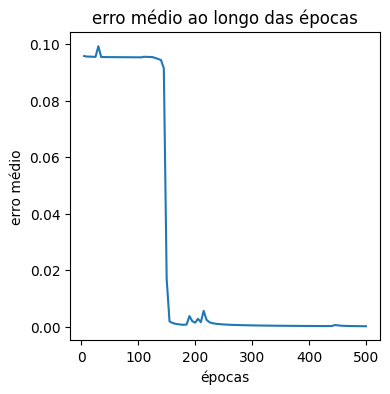

In [965]:
weights_L1 = start_weights(L0, L1)
bias_L1 = start_bias(L1)
weights_L2 = start_weights(L1, L2)
bias_L2 = start_bias(L2)

fit(X_train, y_train)

## Testando o modelo obtido

Primeiro faremos previsões usando o conjunto de teste

In [966]:
predictions = predict(X_test)

## Avaliando o Modelo

### Matriz de confusão

In [967]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def check_confusion_matrix(predictions, y_test, labels):
    y_test_label = label(y_test, labels)
    predictions_label = label(predictions, labels)

    cm = confusion_matrix(y_test_label, predictions_label, labels=labels)

    hm = sns.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels).set(xlabel="previsto", ylabel="alvo")

    hm

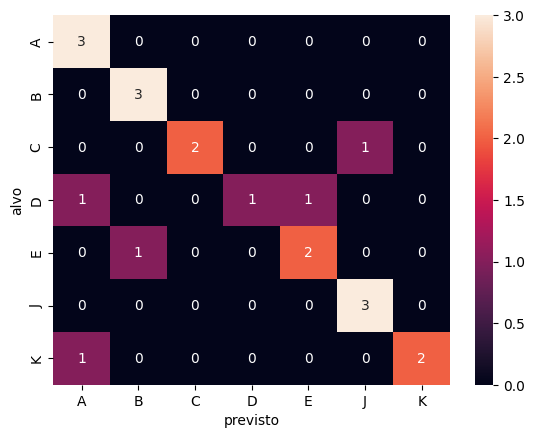

In [968]:
check_confusion_matrix(predictions, y_test, labels)

### Métricas auxiliares

Usamos métricas auxliares para nos ajudar a avaliar o modelo obtido, sendo estas:
 - acurácia
 - precisão
 - revocação
 - f1-score

In [969]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def score_model(predictions, y_test, labels):
    y_test_label = label(y_test, labels)
    predictions_label = label(predictions, labels)

    accuracy = accuracy_score(y_test_label, predictions_label)
    precision = pd.DataFrame(precision_score(y_test_label, predictions_label, average=None, zero_division=0.0), index=labels, columns=['precision'])
    recall = pd.DataFrame(recall_score(y_test_label, predictions_label, average=None), index=labels, columns=['recall'])
    f1 = pd.DataFrame(f1_score(y_test_label, predictions_label, average=None), index=labels, columns=['f1'])

    metrics = precision.join(recall) 
    metrics = metrics.join(f1) 

    print("accuracy:", accuracy)
    return metrics

In [970]:
score = score_model(predictions, y_test, labels)
score

accuracy: 0.7619047619047619


,precision,recall,f1
A,0.600000,1.000000,0.750000
B,0.750000,1.000000,0.857143
C,1.000000,0.666667,0.800000
D,1.000000,0.333333,0.500000
E,0.666667,0.666667,0.666667
J,0.750000,1.000000,0.857143
K,1.000000,0.666667,0.800000


### Cross-Validation

In [978]:
def cross_validation(df, k_size):
    dfs = []
    i = 0
    j = k_size
    while j < len(df.index)+1:
        dfx = df.iloc[i:j]
        i = j
        j += k_size
        dfs.append(pd.DataFrame(dfx))

    X = pd.DataFrame([])


    for i in range(len(dfs)):
        for j in range(len(dfs)):
            if i != j:
                if X.empty:
                    X = dfs[j]
                else:
                    X = pd.concat([X, dfs[j]])
        X_train = X.iloc[:,0:63]
        y_train = X.iloc[:,63:70]
        X_test = dfs[i].iloc[:,0:63]
        y_test = dfs[i].iloc[:,63:70]

        fit(X_train, y_train)
        prediction = predict(X_test)

        check_confusion_matrix(prediction, y_test, labels)
        score = score_model(prediction, y_test, labels)
        print(score)

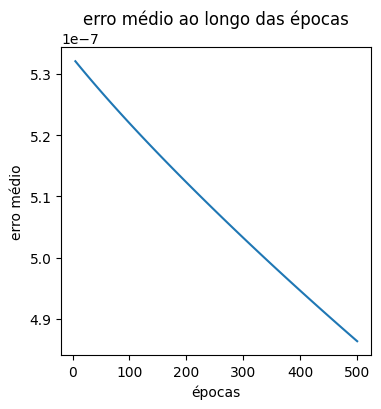

accuracy: 0.9523809523809523
   precision    recall        f1
A       0.75  1.000000  0.857143
B       1.00  1.000000  1.000000
C       1.00  1.000000  1.000000
D       1.00  1.000000  1.000000
E       1.00  1.000000  1.000000
J       1.00  1.000000  1.000000
K       1.00  0.666667  0.800000


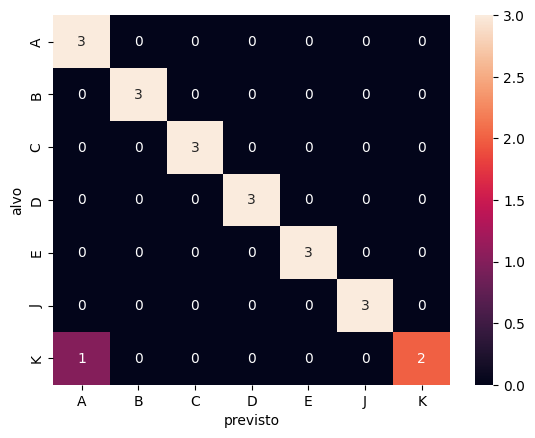

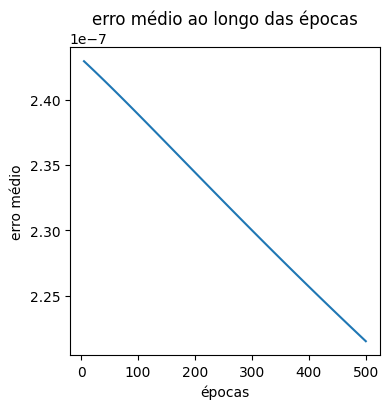

accuracy: 0.9523809523809523
   precision    recall        f1
A       0.75  1.000000  0.857143
B       1.00  1.000000  1.000000
C       1.00  1.000000  1.000000
D       1.00  1.000000  1.000000
E       1.00  1.000000  1.000000
J       1.00  1.000000  1.000000
K       1.00  0.666667  0.800000


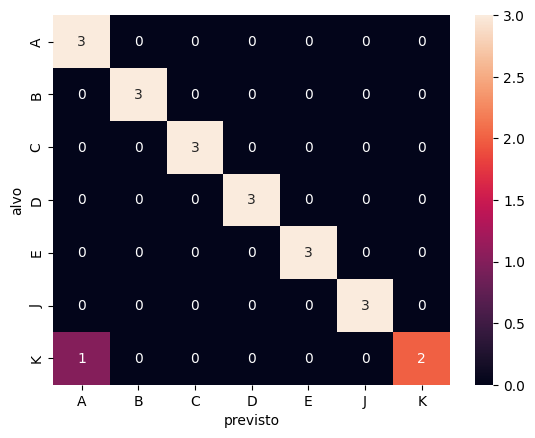

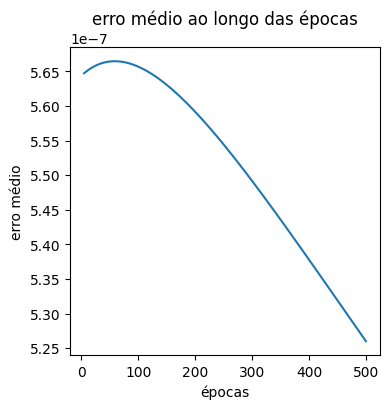

accuracy: 0.9523809523809523
   precision    recall        f1
A       1.00  1.000000  1.000000
B       1.00  1.000000  1.000000
C       1.00  1.000000  1.000000
D       1.00  1.000000  1.000000
E       1.00  1.000000  1.000000
J       0.75  1.000000  0.857143
K       1.00  0.666667  0.800000


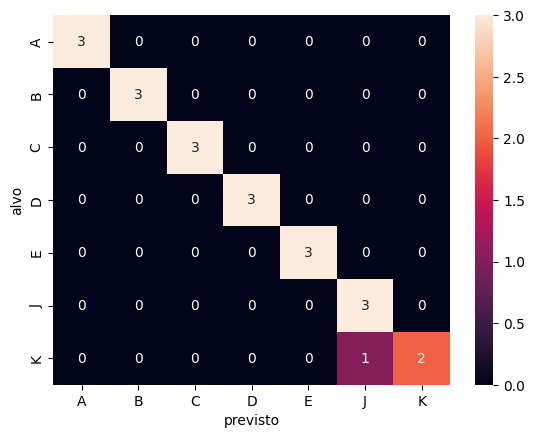

In [975]:
cross_validation(df, 21)